<a href="https://colab.research.google.com/gist/DavidBrynnHouse/9fb6dcae41256f0afe747c6397c33bd9/estimating-windmill-generated-power.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimating Windmill Generated Power

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
from google.colab import files
uploaded = files.upload()

### Data Retrieved from: https://www.kaggle.com/synergystud/a-fine-windy-day-hackerearth-ml-challenge

In [33]:
df = pd.read_csv('wind.csv')

## Data Summary

1. datetime - a string reperesenting the time snapshot when the data was collected
2. wind_speed - a measure of how fast the wind was going in meters per second
3. atmospheric_temperature - ambient temperature in celcius
4. shaft_temperature - the temperature of the windmill shaft in celcius
5. blades_angle - angle of blades in relation to the windstream in degrees
6. gearbox_temperature - the temperature of the windmill gearbox
7. engine_temperature - the temperature of the windmill engine.
8. motor_torque - the torque exerted on the motor in Newton meters
9. generator_temperature - the temperature of the gemerator
10. atmospheric_pressure - the outside pressure measured in pascals
11. area_temperature - the measured temperature around the windmill
12. windmill_body_temperature - the temperature of the windmill body in celcius
13. wind_direction - the direction the wind is pointing in degrees
14. resistance - the electrical resistance of the windmill measured in degrees
15. rotor_torque - the torque exerted by the rotor in Newton meters
16. turbine_status - Unspecified, assumed to be physics condition of the windmill
17. cloud_level - categorical and ordinal description of the cloud level
18. blade_length - the length of the windmill blades in meters
19. blade_bredth - the total bredth of the windmill blades
20. windmill_height - the height of the windmill
21. windmill_generated_power - the power generated by the windmill in kW/h

## Questions

This note book seeks to answer two questions:
* Can the power generated by the windmill be predicted using the provided data?
* Which of the features contributes the most to the genearted power?

In [34]:
df.tracking_id.describe()

count        28200
unique       28200
top       WM_16934
freq             1
Name: tracking_id, dtype: object

Since the count = unique, each instance of a windmill is unique so only a single data point was taken from each windmill.

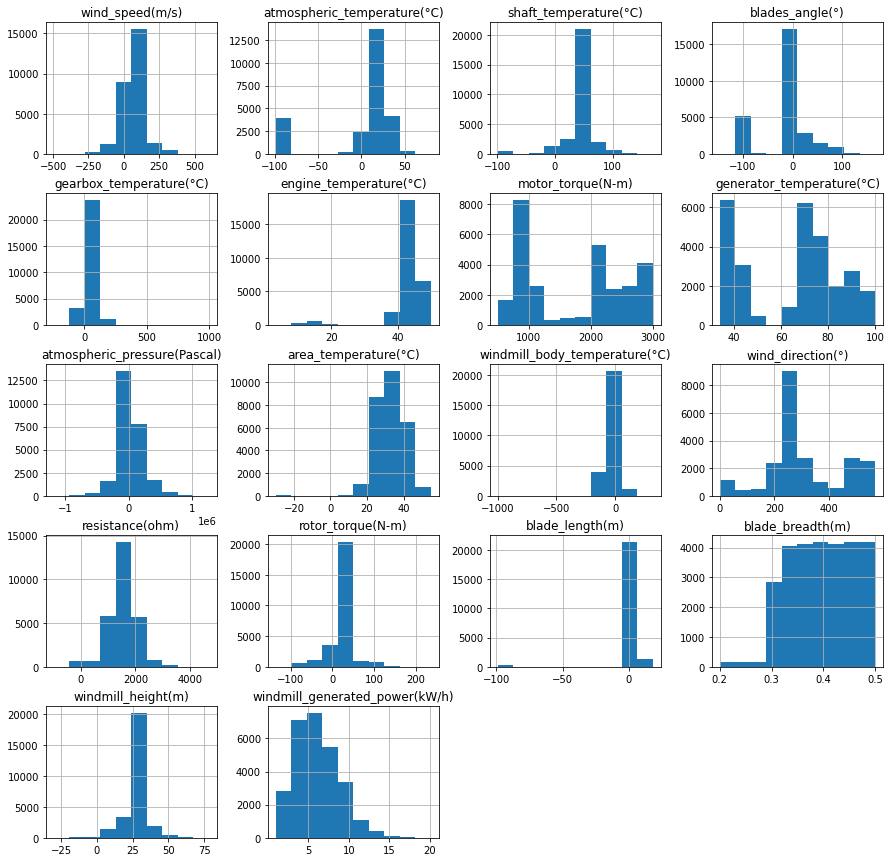

In [22]:
plt.rcParams["figure.figsize"] = (15,15)
df.hist()
plt.show()

There are definitely some suspicious data points that we want to investigate. For example: several features are measured in meters yet there are negative values given, which makes no sense. Another point which is impossible is an atmospheric temperature of -100 degrees celcius. This makes no sense as the coldest recorded temperature it -89 degrees celcius. Something else I would be curious about is the range of windspeeds which fluctuates between -250 and 250 m/s (~560mph), however windmills are generally rated to operate in winds of 35 mph. Finally there are several pressure readings below zero which does not make sense. 

In [23]:
df["wind_speed(m/s)"] = abs(df["wind_speed(m/s)"])
df["atmospheric_pressure(Pascal)"] = abs(df["atmospheric_pressure(Pascal)"])
df["blade_length(m)"] = abs(df["blade_length(m)"])
df["windmill_height(m)"] = abs(df["windmill_height(m)"])

I am assming that all of the negative values for lengths and width are spurious and converting them using the absolute value. This gives more resonable measurements but we still have to deal with the extreme values which appear in the dataset.

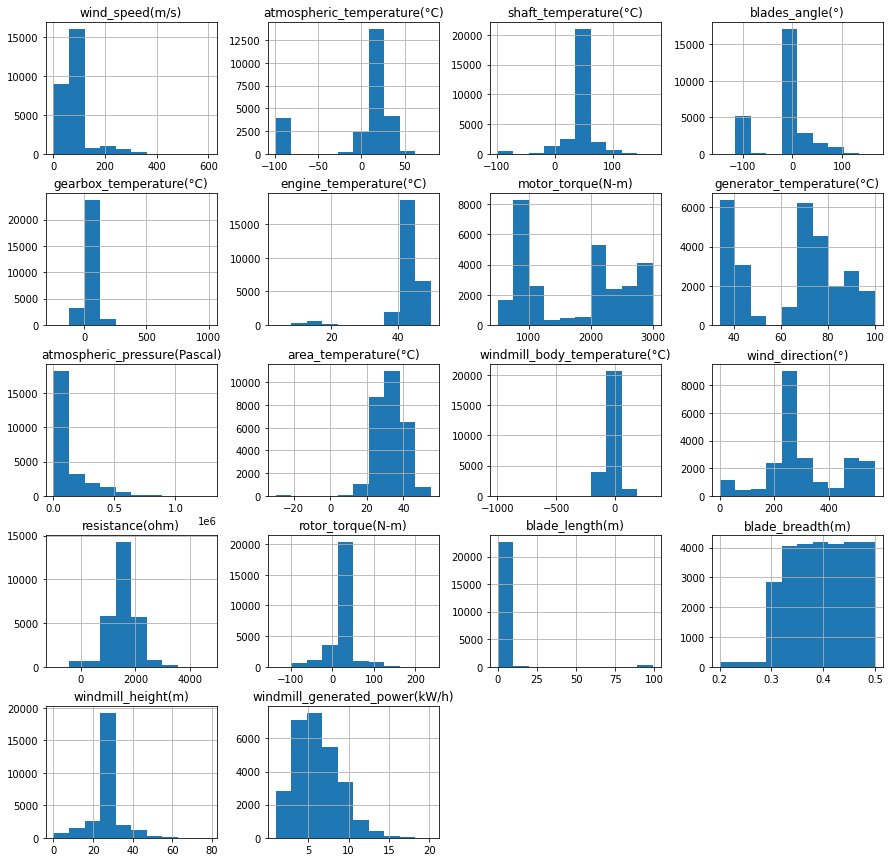

In [24]:
plt.rcParams["figure.figsize"] = (15,15)
df.hist()
plt.show()

In [25]:
df["wind_speed(m/s)"].describe()

count    27927.000000
mean        83.842915
std         59.618586
min          1.768248
25%         34.136048
50%         93.625319
75%         95.611575
max        601.455670
Name: wind_speed(m/s), dtype: float64

This shows me that I should not rely on this feature to make any determinations. A mean wind speed of 83m/s is far beyond the capacity of a wind mill and would probably result in damage to the turbine. Not to mention that the max wind speed of 601m/s(1344mph) is 10 times faster than a category 5 hurricane. There is obviously something deeply wrong with these measurements, and I will be ignoring this feature in my regression.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28200 entries, 0 to 28199
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   tracking_id                     28200 non-null  object 
 1   datetime                        28200 non-null  object 
 2   wind_speed(m/s)                 27927 non-null  float64
 3   atmospheric_temperature(°C)     24750 non-null  float64
 4   shaft_temperature(°C)           28198 non-null  float64
 5   blades_angle(°)                 27984 non-null  float64
 6   gearbox_temperature(°C)         28199 non-null  float64
 7   engine_temperature(°C)          28188 non-null  float64
 8   motor_torque(N-m)               28176 non-null  float64
 9   generator_temperature(°C)       28188 non-null  float64
 10  atmospheric_pressure(Pascal)    25493 non-null  float64
 11  area_temperature(°C)            28200 non-null  float64
 12  windmill_body_temperature(°C)   

All of the data appear to be of the proper datatype. The only exception being the datetime property. We convert this below.

In [27]:
df.datetime = pd.to_datetime(df.datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28200 entries, 0 to 28199
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   tracking_id                     28200 non-null  object        
 1   datetime                        28200 non-null  datetime64[ns]
 2   wind_speed(m/s)                 27927 non-null  float64       
 3   atmospheric_temperature(°C)     24750 non-null  float64       
 4   shaft_temperature(°C)           28198 non-null  float64       
 5   blades_angle(°)                 27984 non-null  float64       
 6   gearbox_temperature(°C)         28199 non-null  float64       
 7   engine_temperature(°C)          28188 non-null  float64       
 8   motor_torque(N-m)               28176 non-null  float64       
 9   generator_temperature(°C)       28188 non-null  float64       
 10  atmospheric_pressure(Pascal)    25493 non-null  float64       
 11  ar

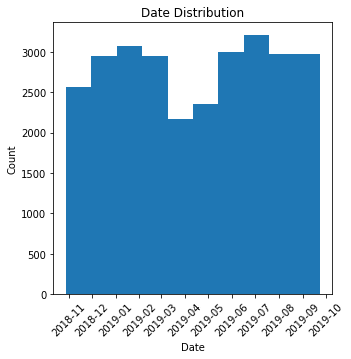

In [28]:
plt.rcParams["figure.figsize"] = (5,5)
plt.hist(df.datetime)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Date Distribution')
plt.show()

From this graph we can see that the measurements were taken over a period of one year, with slightly fewer being taken during the spring.

In [29]:
df.isna().sum()

tracking_id                          0
datetime                             0
wind_speed(m/s)                    273
atmospheric_temperature(°C)       3450
shaft_temperature(°C)                2
blades_angle(°)                    216
gearbox_temperature(°C)              1
engine_temperature(°C)              12
motor_torque(N-m)                   24
generator_temperature(°C)           12
atmospheric_pressure(Pascal)      2707
area_temperature(°C)                 0
windmill_body_temperature(°C)     2363
wind_direction(°)                 5103
resistance(ohm)                      1
rotor_torque(N-m)                  572
turbine_status                    1759
cloud_level                        276
blade_length(m)                   5093
blade_breadth(m)                     0
windmill_height(m)                 543
windmill_generated_power(kW/h)     207
dtype: int64

Here we can see that there are a good number of na values throughout the data. Before we perform any regression on this we will need to address this.

In [30]:
# deleting columns to make plotting easier
del df['tracking_id']
del df['datetime']
del df['cloud_level']
del df['turbine_status']

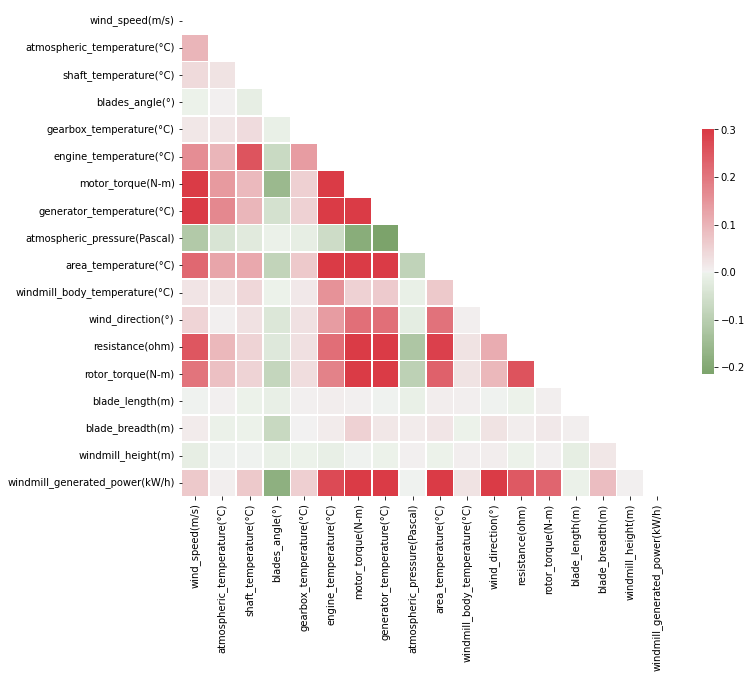

In [31]:
# Used example code from: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

import seaborn as sns
# Compute the correlation matrix
corr = abs(df).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(120, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From this we can see there are several features which are corralated slightly with the power generated. This will be useful to know when we perform our regression.